In [22]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import sqlite3
import numpy as np


from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.preprocessing import scale, MinMaxScaler

In [2]:
conn = sqlite3.connect('soccer/database.sqlite')
player_data = pd.read_sql("SELECT * FROM Player;", conn)
player_stats_data = pd.read_sql("SELECT * FROM Player_Attributes;", conn)
team_data = pd.read_sql("SELECT * FROM Team;", conn)
match_data = pd.read_sql("SELECT * FROM Match;", conn)

In [3]:
print(player_data.info(), '\n')
print(player_stats_data.info(), '\n')
print(team_data.info(), '\n')
print(match_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11060 entries, 0 to 11059
Data columns (total 7 columns):
id                    11060 non-null int64
player_api_id         11060 non-null int64
player_name           11060 non-null object
player_fifa_api_id    11060 non-null int64
birthday              11060 non-null object
height                11060 non-null float64
weight                11060 non-null int64
dtypes: float64(1), int64(4), object(2)
memory usage: 604.9+ KB
None 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 183978 entries, 0 to 183977
Data columns (total 42 columns):
id                     183978 non-null int64
player_fifa_api_id     183978 non-null int64
player_api_id          183978 non-null int64
date                   183978 non-null object
overall_rating         183142 non-null float64
potential              183142 non-null float64
preferred_foot         183142 non-null object
attacking_work_rate    180748 non-null object
defensive_work_rate    183142 non-null

In [4]:
match_data.head(1)

,id,country_id,league_id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,...,SJA,VCH,VCD,VCA,GBH,GBD,GBA,BSH,BSD,BSA
0,1,1,1,2008/2009,1,2008-08-17 00:00:00,492473,9987,9993,1,...,4.0,1.65,3.4,4.5,1.78,3.25,4.0,1.73,3.4,4.2


In [5]:
list(match_data)

['id',
 'country_id',
 'league_id',
 'season',
 'stage',
 'date',
 'match_api_id',
 'home_team_api_id',
 'away_team_api_id',
 'home_team_goal',
 'away_team_goal',
 'home_player_X1',
 'home_player_X2',
 'home_player_X3',
 'home_player_X4',
 'home_player_X5',
 'home_player_X6',
 'home_player_X7',
 'home_player_X8',
 'home_player_X9',
 'home_player_X10',
 'home_player_X11',
 'away_player_X1',
 'away_player_X2',
 'away_player_X3',
 'away_player_X4',
 'away_player_X5',
 'away_player_X6',
 'away_player_X7',
 'away_player_X8',
 'away_player_X9',
 'away_player_X10',
 'away_player_X11',
 'home_player_Y1',
 'home_player_Y2',
 'home_player_Y3',
 'home_player_Y4',
 'home_player_Y5',
 'home_player_Y6',
 'home_player_Y7',
 'home_player_Y8',
 'home_player_Y9',
 'home_player_Y10',
 'home_player_Y11',
 'away_player_Y1',
 'away_player_Y2',
 'away_player_Y3',
 'away_player_Y4',
 'away_player_Y5',
 'away_player_Y6',
 'away_player_Y7',
 'away_player_Y8',
 'away_player_Y9',
 'away_player_Y10',
 'away_player

In [6]:
features = ['home_team_goal', 
        'away_team_goal', 
        'date', 
        'B365H',
        'B365D',
        'B365A',
        'BWH',
        'BWD',
        'BWA',
        'IWH',
        'IWD',
        'IWA',
        'LBH',
        'LBD',
        'LBA',
        'PSH',
        'PSD',
        'PSA',
        'WHH',
        'WHD',
        'WHA',
        'SJH',
        'SJD',
        'SJA',
        'VCH',
        'VCD',
        'VCA',
        'GBH',
        'GBD',
        'GBA',
        'BSH',
        'BSD',
        'BSA']
match_df = match_data[features].copy()

In [7]:
# Computing value to predict
match_df['home_wins'] = np.where(match_df['home_team_goal'] > match_df['away_team_goal'], True, False)
match_df = match_df.drop(['home_team_goal', 'away_team_goal'], axis=1)

In [8]:
# Converting date properly
match_df["date"] = pd.to_datetime(match_df["date"])
match_df["year"] = match_df["date"].dt.year
match_df["month"] = match_df["date"].dt.month
match_df["day"] = match_df["date"].dt.day
match_df = match_df.drop("date", axis=1)

In [10]:
match_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25979 entries, 0 to 25978
Data columns (total 34 columns):
B365H        22592 non-null float64
B365D        22592 non-null float64
B365A        22592 non-null float64
BWH          22575 non-null float64
BWD          22575 non-null float64
BWA          22575 non-null float64
IWH          22520 non-null float64
IWD          22520 non-null float64
IWA          22520 non-null float64
LBH          22556 non-null float64
LBD          22556 non-null float64
LBA          22556 non-null float64
PSH          11168 non-null float64
PSD          11168 non-null float64
PSA          11168 non-null float64
WHH          22571 non-null float64
WHD          22571 non-null float64
WHA          22571 non-null float64
SJH          17097 non-null float64
SJD          17097 non-null float64
SJA          17097 non-null float64
VCH          22568 non-null float64
VCD          22568 non-null float64
VCA          22568 non-null float64
GBH          14162 non-null

We see that both Gamebookers and Pinnacle have unusually high numbers of NaN. We decide to suppress them from the DB

In [11]:
# match_df = scale(match_df)
# for i in range(30):
#     indices = pd.notnull(match_df[[i]])
#     match_df[[i]][indices] = scale(match_df[[i]][indices])
    #match_df[[i]][indices] = (match_df[[i]][indices] - match_df[[i]][indices].match_d

In [12]:
# match_df = match_df.drop(['GBH', 'GBD', 'GBA'], axis=1)
# match_df = match_df.drop(['SJH', 'SJD', 'SJA'], axis=1)
match_df = match_df.drop(['PSH', 'PSD', 'PSA'], axis=1)

In [13]:
# First method: replace NaN by median
# match_df = match_df.fillna(match_df.median())
# match_df.info()

# Hybrid 2nd method
match_df = match_df.dropna(axis=0, subset=['SJH'])
match_df = match_df.fillna(match_df.median())

In [14]:
match_df = shuffle(match_df)
y_tot = match_df['home_wins']
X_tot = match_df.drop('home_wins', axis=1)

X_train, X_val, y_train, y_val = train_test_split(X_tot, y_tot, test_size=0.1)

# Random Forest Classifiers

Forest  50 out of 200 computed
Forest  56 out of 200 computed
Forest  62 out of 200 computed
Forest  68 out of 200 computed
Forest  75 out of 200 computed
Forest  81 out of 200 computed
Forest  87 out of 200 computed
Forest  93 out of 200 computed
Forest  100 out of 200 computed
Forest  106 out of 200 computed
Forest  112 out of 200 computed
Forest  118 out of 200 computed
Forest  125 out of 200 computed
Forest  131 out of 200 computed
Forest  137 out of 200 computed
Forest  143 out of 200 computed
Forest  150 out of 200 computed
Forest  156 out of 200 computed
Forest  162 out of 200 computed
Forest  168 out of 200 computed
Forest  175 out of 200 computed
Forest  181 out of 200 computed
Forest  187 out of 200 computed
Forest  193 out of 200 computed
Forest  200 out of 200 computed


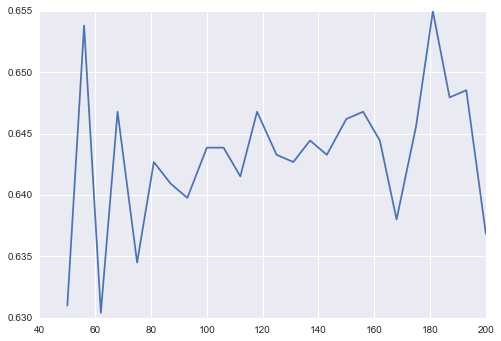

In [15]:
n_trees = np.linspace(50, 200, num=25, dtype=int)
scores = []
for n in n_trees:
    print('Forest ', n, 'out of 200 computed')
    clf = RandomForestClassifier(n_estimators=n)
    clf.fit(X_train, y_train)
    scores.append(clf.score(X_val, y_val))
plt.plot(n_trees, scores)

We get with this method a maximal score of approx. 63.5%

One idea to get a better model is to avoid overfitting by preventing trees from being too depth

In [16]:
[estimator.tree_.max_depth for estimator in clf.estimators_]

[38,
 33,
 32,
 36,
 36,
 37,
 35,
 32,
 36,
 35,
 34,
 37,
 39,
 37,
 42,
 40,
 34,
 30,
 37,
 37,
 37,
 42,
 43,
 37,
 40,
 39,
 37,
 32,
 39,
 35,
 39,
 38,
 31,
 39,
 34,
 32,
 39,
 38,
 32,
 40,
 38,
 35,
 30,
 36,
 31,
 33,
 33,
 37,
 34,
 38,
 35,
 43,
 35,
 35,
 33,
 35,
 36,
 37,
 33,
 36,
 36,
 36,
 40,
 33,
 33,
 38,
 42,
 35,
 43,
 33,
 37,
 40,
 34,
 33,
 31,
 33,
 45,
 36,
 34,
 35,
 35,
 39,
 37,
 40,
 35,
 32,
 39,
 34,
 31,
 35,
 30,
 35,
 40,
 41,
 40,
 44,
 32,
 34,
 36,
 40,
 39,
 35,
 38,
 39,
 41,
 41,
 44,
 41,
 37,
 39,
 38,
 34,
 40,
 40,
 37,
 35,
 39,
 39,
 29,
 33,
 42,
 29,
 38,
 34,
 34,
 41,
 41,
 34,
 38,
 41,
 41,
 40,
 35,
 37,
 33,
 37,
 43,
 33,
 32,
 38,
 39,
 41,
 34,
 33,
 33,
 32,
 35,
 36,
 42,
 38,
 32,
 45,
 34,
 39,
 38,
 47,
 36,
 45,
 39,
 37,
 37,
 41,
 35,
 32,
 36,
 36,
 34,
 37,
 40,
 37,
 43,
 34,
 33,
 34,
 37,
 39,
 36,
 38,
 35,
 36,
 40,
 32,
 39,
 34,
 43,
 37,
 39,
 35,
 35,
 39,
 33,
 43,
 37,
 39,
 37,
 37,
 38,
 38,
 32,
 42]

Forest  50 out of 200 computed
Forest  56 out of 200 computed
Forest  62 out of 200 computed
Forest  68 out of 200 computed
Forest  75 out of 200 computed
Forest  81 out of 200 computed
Forest  87 out of 200 computed
Forest  93 out of 200 computed
Forest  100 out of 200 computed
Forest  106 out of 200 computed
Forest  112 out of 200 computed
Forest  118 out of 200 computed
Forest  125 out of 200 computed
Forest  131 out of 200 computed
Forest  137 out of 200 computed
Forest  143 out of 200 computed
Forest  150 out of 200 computed
Forest  156 out of 200 computed
Forest  162 out of 200 computed
Forest  168 out of 200 computed
Forest  175 out of 200 computed
Forest  181 out of 200 computed
Forest  187 out of 200 computed
Forest  193 out of 200 computed
Forest  200 out of 200 computed


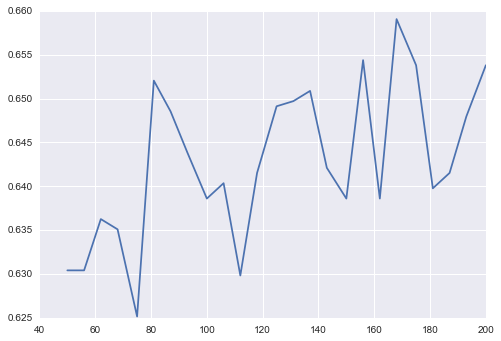

In [17]:
n_trees = np.linspace(50, 200, num=25, dtype=int)
scores = []
for n in n_trees:
    print('Forest ', n, 'out of 200 computed')
    clf = RandomForestClassifier(n_estimators=n, max_depth=35)
    clf.fit(X_train, y_train)
    scores.append(clf.score(X_val, y_val))
plt.plot(n_trees, scores)

Sans normalisation et sans remplacer les grosses données manquantes : score 0.635

In [21]:
# Finding best value to keep
n_RF = n_trees[np.argmax(np.array(scores))]
score_RF = max(scores) 

# Boosting Classifiers

In [24]:
# Basic use
clf_boost = GradientBoostingClassifier()
clf_boost.fit(X_train, y_train)
print(clf_boost.score(X_val, y_val))

0.653216374269


In [30]:
# Fiddling with parameters
clf_boost = GradientBoostingClassifier(n_estimators=200, learning_rate=0.05)
clf_boost.fit(X_train, y_train)
print(clf_boost.score(X_val, y_val))

0.657894736842


Boosting seems to offer significantly better results. That is why we decide to use it on the overall dataset.

In [31]:
clf_final = GradientBoostingClassifier(n_estimators=200, learning_rate=0.05)
clf_final.fit(X_tot, y_tot)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.05, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=200, presort='auto', random_state=None,
              subsample=1.0, verbose=0, warm_start=False)